# Add New Explanation Backend

---

This notebook is part of the [CaTabRa GitHub repository](https://github.com/risc-mi/catabra).

This notebook demonstrates how a new explanation backend can be added to CaTabRa, i.e.,

* [how it can be implemented](#Implement-Random-Explainer), and
* [how it can be utilized in CaTabRa's data analysis workflow](#Utilize-Random-Explainer).

## Implement Random Explainer

We implement a new dummy explanation backend that returns random feature importance scores. If you intend to actually add a new explanation backend, don't forget to have a look at the implementation of the existing SHAP and permutation importance backends in [`catabra.explanation._shap.backend`](https://github.com/risc-mi/catabra/tree/main/catabra/explanation/_shap/backend.py) and [`catabra.explanation._permutation.backend`](https://github.com/risc-mi/catabra/tree/main/catabra/explanation/_permutation/backend.py), respectively.

In [2]:
from typing import Optional
import numpy as np
import pandas as pd

from catabra.explanation.base import TransformationExplainer, IdentityTransformationExplainer, EnsembleExplainer
from catabra.automl.base import FittedEnsemble

Explanation backends need to implement the abstract base class [`catabra.explanation.base.EnsembleExplainer`](https://github.com/risc-mi/catabra/tree/main/catabra/explanation/base.py). The main methods of interest are `explain()` and `explain_global()` for producing local (sample-wise) and global explanations, respectively.

In [3]:
class RandomEnsembleExplainer(EnsembleExplainer):
    
    @property
    def name(self) -> str:
        return 'random_explainer'
    
    @property
    def behavior(self) -> dict:
        return dict(
            supports_local=True,
            requires_y=False,
            global_accepts_x=True,
            global_requires_x=True,
            global_is_mean_of_local=True
        )
    
    def __init__(self, ensemble: FittedEnsemble = None, config: Optional[dict] = None,
             feature_names: Optional[list] = None, target_names: Optional[list] = None,
             x: Optional[pd.DataFrame] = None, y: Optional[pd.DataFrame] = None, params=None):
        super(RandomEnsembleExplainer, self).__init__(ensemble=ensemble, config=config, feature_names=feature_names,
                                                      target_names=target_names, x=x, y=y, params=params)
        
        # `ensemble` is the ensemble of one or more models we will explain,
        #    in the uniform `FittedEnsemble` representation.
        # Note: If the explainer needs to know the prediction task `ensemble` was trained for
        #    (binary/multiclass/multilabel classification, regression),
        #    it can be accessed via `ensemble.task`.
        self._ensemble = ensemble
        
        if params is None:
            assert x is not None
            if feature_names is None:
                self._feature_names = list(range(x.shape[1]))
            else:
                assert len(feature_names) == x.shape[1]
                self._feature_names = feature_names
            self._params = dict(feature_names=self._feature_names)
        else:
            self._params = params
            self._feature_names = self._params['feature_names']
    
    @property
    def params_(self) -> dict:
        return self._params
    
    def explain(self, x: pd.DataFrame, y: Optional[pd.DataFrame]=None, jobs: int = 1, batch_size: Optional[int] = None,
                model_id=None, mapping: Optional[dict] = None, show_progress: bool = False) -> dict:
        if model_id is None:
            keys = ['__ensemble__']
        elif not isinstance(model_id, (list, set)):
            keys = [model_id]
        else:
            keys = model_id
        
        # explain models with IDs in `keys` on data `x`,
        # and return DataFrames with one row per sample and one column per feature
        
        return {
            k: pd.DataFrame(
                index=x.index,
                columns=self._feature_names,
                data=np.random.uniform(-1, 1, size=(len(x), len(self._feature_names)))
            )
            for k in keys
        }
    
    def explain_global(self, x: Optional[pd.DataFrame] = None, sample_weight: Optional[np.ndarray] = None,
                       jobs: int = 1, batch_size: Optional[int] = None, model_id=None,
                       mapping: Optional[dict] = None, show_progress: bool = False) -> dict:
        local_explanation = self.explain(x, jobs=jobs, batch_size=batch_size, model_id=model_id,
                                         mapping=mapping, show_progress=show_progress)
        return {k: e.mean(axis=0) for k, e in local_explanation.items()}
    
    def get_versions(self) -> dict:
        return {}

Finally, the new backend needs to be registered:

In [4]:
EnsembleExplainer.register('random_explainer', RandomEnsembleExplainer)

## Utilize Random Explainer

We now utilize the new `"random_explainer"` in a simple classification problem. Everthing shown works analogously for all other prediction tasks.

In [5]:
# load dataset
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(as_frame=True, return_X_y=True)

In [6]:
# add target labels to DataFrame
X['diagnosis'] = y

In [7]:
# split into train- and test set by adding column with corresponding values
# the name of the column is arbitrary; CaTabRa tries to "guess" which samples belong to which set based on the column name and -values
X['train'] = X.index <= 0.8 * len(X)

When analyzing the data, we inform CaTabRa that we want to use the `"random_explainer"` backend by adjusting the config dict (strictly speaking, this is only necessary if the explainer needs to be fit to training data):

In [8]:
from catabra.analysis import analyze

analyze(
    X,
    classify='diagnosis',     # name of column containing classification target
    split='train',            # name of column containing information about the train-test split (optional)
    time=1,                   # time budget for hyperparameter tuning, in minutes (optional)
    out='random_explainer_example',
    config={
        'explainer': 'random_explainer'     # name of the explanation backend
    }
)

[CaTabRa] ### Analysis started at 2023-04-13 12:17:10.550203
[CaTabRa] Saving descriptive statistics completed


/mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/catabra/util/statistics.py:213: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return dict_stat, dict_non_num_stat, (df.corr() if df.shape[1] <= corr_threshold else None)


[CaTabRa] Using AutoML-backend auto-sklearn for binary_classification
[CaTabRa] Successfully loaded the following auto-sklearn add-on module(s): xgb
[CaTabRa] Using auto-sklearn 2.0.


/home/skaltenl/anaconda3/envs/test2/lib/python3.9/site-packages/autosklearn/experimental/selector.py:24: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():
/home/skaltenl/anaconda3/envs/test2/lib/python3.9/site-packages/smac/intensification/parallel_scheduling.py:153: UserWarning: SuccessiveHalving is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(


[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.986260
    n_constituent_models: 1
    total_elapsed_time: 00:07
[CaTabRa] New model #1 trained:
    val_roc_auc: 0.989845
    val_accuracy: 0.947368
    val_balanced_accuracy: 0.946356
    train_roc_auc: 1.000000
    type: gradient_boosting
    total_elapsed_time: 00:07
[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.986260
    n_constituent_models: 1
    total_elapsed_time: 00:09
[CaTabRa] New model #2 trained:
    val_roc_auc: 0.945430
    val_accuracy: 0.921053
    val_balanced_accuracy: 0.924134
    train_roc_auc: 1.000000
    type: gradient_boosting
    total_elapsed_time: 00:09
[CaTabRa] New ensemble fitted:
    ensemble_val_roc_auc: 0.986260
    n_constituent_models: 1
    total_elapsed_time: 00:12
[CaTabRa] New model #3 trained:
    val_roc_auc: 0.971416
    val_accuracy: 0.921053
    val_balanced_accuracy: 0.919952
    train_roc_auc: 0.993877
    type: gradient_boosting
    total_elapsed_time: 00:11
[CaTabR

/home/skaltenl/anaconda3/envs/test2/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:3237: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/skaltenl/anaconda3/envs/test2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/skaltenl/anaconda3/envs/test2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(


[CaTabRa] Final training statistics:
    n_models_trained: 16
    ensemble_val_roc_auc: 0.9971724412584628
[CaTabRa] Creating random_explainer explainer
[CaTabRa] Initialized out-of-distribution detector of type BinsDetector
[CaTabRa] Fitting out-of-distribution detector...
[CaTabRa] Out-of-distribution detector fitted.
[CaTabRa] ### Analysis finished at 2023-04-13 12:18:10.490961
[CaTabRa] ### Elapsed time: 0 days 00:00:59.940758
[CaTabRa] ### Output saved in /mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/examples/random_explainer_example
[CaTabRa] ### Evaluation started at 2023-04-13 12:18:10.512848
[CaTabRa] Saving descriptive statistics completed
[CaTabRa] Predicting out-of-distribution samples.


/mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/catabra/util/statistics.py:213: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return dict_stat, dict_non_num_stat, (df.corr() if df.shape[1] <= corr_threshold else None)


[CaTabRa] Saving descriptive statistics completed
[CaTabRa] Predicting out-of-distribution samples.
[CaTabRa] Evaluation results for train:
    roc_auc: 0.9990442054958184
    accuracy @ 0.5: 0.9824561403508771
    balanced_accuracy @ 0.5: 0.9818399044205496


/mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/catabra/util/statistics.py:213: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  return dict_stat, dict_non_num_stat, (df.corr() if df.shape[1] <= corr_threshold else None)


[CaTabRa] Evaluation results for not_train:
    roc_auc: 0.9995579133510168
    accuracy @ 0.5: 0.9734513274336283
    balanced_accuracy @ 0.5: 0.9827586206896552
[CaTabRa] ### Evaluation finished at 2023-04-13 12:18:13.383042
[CaTabRa] ### Elapsed time: 0 days 00:00:02.870194
[CaTabRa] ### Output saved in /mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/examples/random_explainer_example/eval


The rest proceeds as usual:

In [9]:
from catabra.explanation import explain

explain(
    X,
    folder='random_explainer_example',
    from_invocation='random_explainer_example/invocation.json',
    out='random_explainer_example/explain'
)

[CaTabRa] ### Explanation started at 2023-04-13 12:18:13.398007
[CaTabRa] *** Split train
[CaTabRa] *** Split not_train
[CaTabRa] ### Explanation finished at 2023-04-13 12:18:16.667998
[CaTabRa] ### Elapsed time: 0 days 00:00:03.269991
[CaTabRa] ### Output saved in /mnt/c/Users/skaltenl/Documents/catabra_2023/develop/catabra/examples/random_explainer_example/explain


In [10]:
from catabra.util.io import read_df
ex = read_df('random_explainer_example/explain/not_train/__ensemble__.h5')

As can be seen, the feature importance scores are completely random:

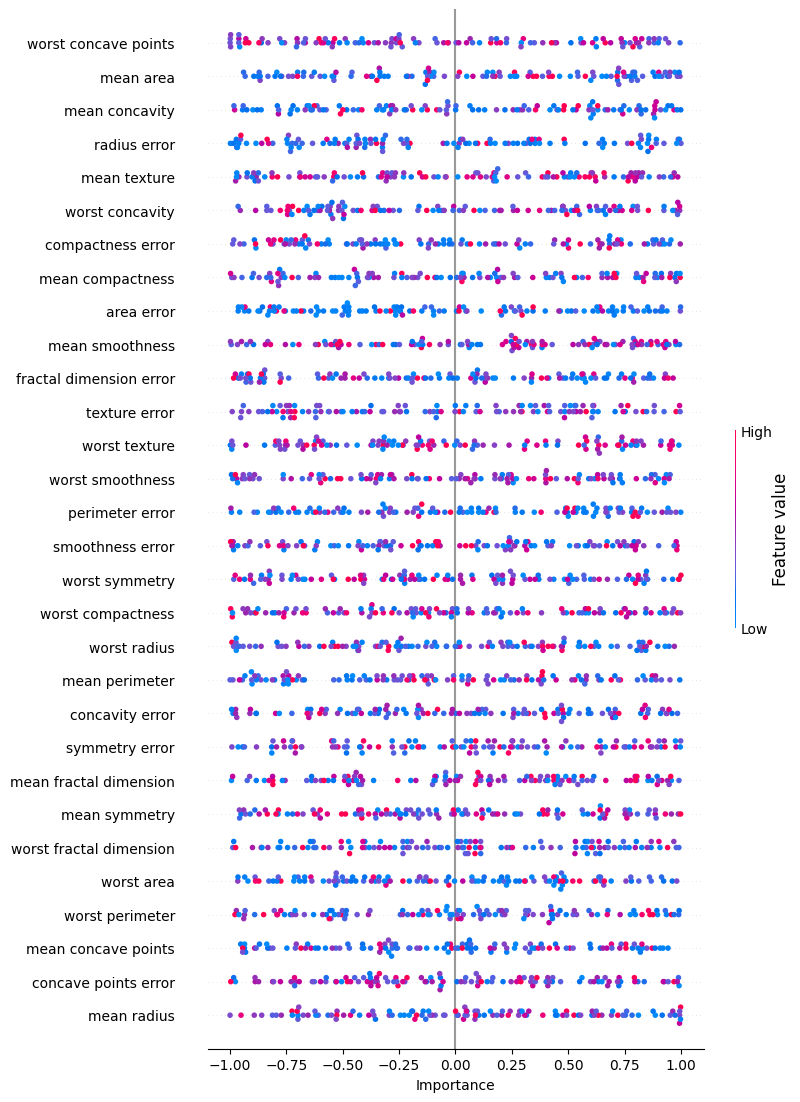

In [11]:
from catabra.explanation import plot_beeswarms
plot_beeswarms(ex, features=X[~X['train']])